In [3]:
from astropy.io import ascii
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import asarray as ar, exp
from scipy.optimize import curve_fit, least_squares
import re
%matplotlib inline

snls_colors = {"sdssg":"darkgreen", "sdssi":"darkblue", "sdssr":"darkred", "sdssz":"purple"}
base_colors = {"sdssg":"green", "sdssi":"blue", "sdssr":"red", "sdssz":"magenta"}

import astropy.coordinates as coord
import astropy.units as u
import Utils.DiaSourceTools as DSTools

import sncosmo

In [4]:
def show_multi_filter_light_curve(t, colors, n_factor = None, conv='.'):
   
    t_by_filter = t.group_by("bandpass")

    indices = t_by_filter.groups.indices
    
    #print indices
    for i in range(0, len(indices)-1):
        
        data = t_by_filter[indices[i]:indices[i+1]]
        
        if n_factor is not None:
            value = n_factor[data[0]["bandpass"]]
            f = value if np.isnan(value) == False else 1
            plt.errorbar(data["mjd"], data["flux"]*f,yerr=data["flux_error"]*f, fmt=conv, markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])            
        else:
            plt.errorbar(data["mjd"], data["flux"],yerr=data["flux_error"], fmt=conv, markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])
    plt.legend()
    #plt.show()
    
def mod_gauss(t, a, t0, tf, tr, b):
    return a*((exp(-(t-t0)/tf))/(1+exp(-(t-t0)/tr)))+b

def get_max_index(fluxes):
    max_val = 0
    max_index = -1
    for i, elem in enumerate(fluxes):
        
        if max_val<elem:
            max_val = elem
            max_index = i
            
    return max_index

    
def show_fit_mod_gaussians(t, colors, n_factor = None, plot=True, show_means=False):

    
    t_by_filter = t.group_by("bandpass")

    
    min_date = min(t["mjd"])
    max_date = max(t["mjd"])
    
     
    indices = t_by_filter.groups.indices
    
    #max_i = get_max_index(t_by_filter["flux"])
    #mean_date = t_by_filter[max_i]["mjd"]-min_date
    
  
    for i in range(0, len(indices)-1):

        data = t_by_filter[indices[i]:indices[i+1]]
        x = data["mjd"]-min_date
        y = data["flux"]
        
        
        max_i = get_max_index(data["flux"])
        mean_date = data[max_i]["mjd"]-min_date
        
        
        n = len(x)
        sigma = np.std(y)
        
        
        popt, pcov = curve_fit(mod_gauss, x, y, p0=[data[max_i]["flux"], mean_date, 2, 1.5, 0], maxfev=500000,  sigma = data["flux_error"])
        
        
        c = (y - mod_gauss(x, *popt))
        chi = (y - mod_gauss(x, *popt))/data["flux_error"]
    
        chi2 = (chi**2).sum()
        dof = len(x) - len(popt)

        #print len(x) - len(popt)
        #print (chi2 / (len(x)-len(popt)))
        if plot==True:
            plt.plot(x, y, 'b+', color=colors[data[0]["bandpass"]])
            
            X = np.arange(0,max_date-min_date,1)

            plt.plot(X, mod_gauss(X, *popt), color=colors[data[0]["bandpass"]])
            if show_means:
                print mean_date
                plt.axvline(x=mean_date, color=colors[data[0]["bandpass"]], linestyle="dotted")
            plt.xlim(xmin=-10)
        #print gauss(X, *popt)
        #plt.xlim(xmin=400, xmax=500)
        #plt.show()
        #plt.legend()
    #plt.show()
    return popt, pcov, chi2, dof

    


In [6]:
lienObj = glob.glob("/datadec/cppm/jpreyes/CFHT_Production/light_curves_candidates/*.dat")

In [7]:
def f(obj):
    table = ascii.read(obj)
    return table

import multiprocessing
try:
    pool = multiprocessing.Pool()
    res =  pool.map(f, lienObj)
finally:
    pool.close()

In [9]:
s_candidates = res

In [4]:
snls_array = []
for sn in elems:

        c = coord.SkyCoord(sn[1], unit=(u.hourangle, u.deg))

        m = re.findall('^'+str(sn[0])+'\\|(r|g|z|i)\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

        snls_lc = DSTools.build_light_curve_from_snls_file_2(m, c, sn[0], sn[-1])

        if len(m)>0:
            #print sn[0], c.ra.deg, c.dec.deg

            #plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
            #show_multi_filter_light_curve(snls_lc, snls_colors)
            plt.show()
            snls_array.append(snls_lc)

print("total of sn:" + str(len(snls_array)))

total of sn:83


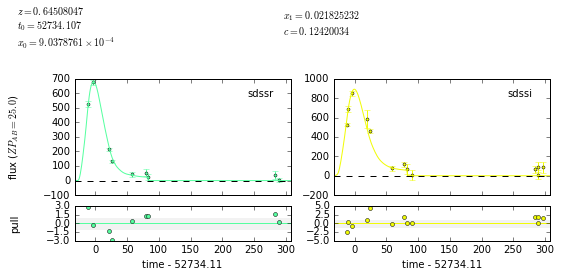

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:160: RuntimeWarning: Dropping following bands from data: sdssz, sdssg(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


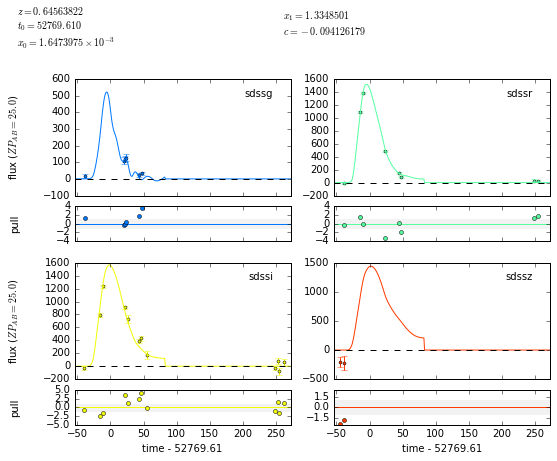

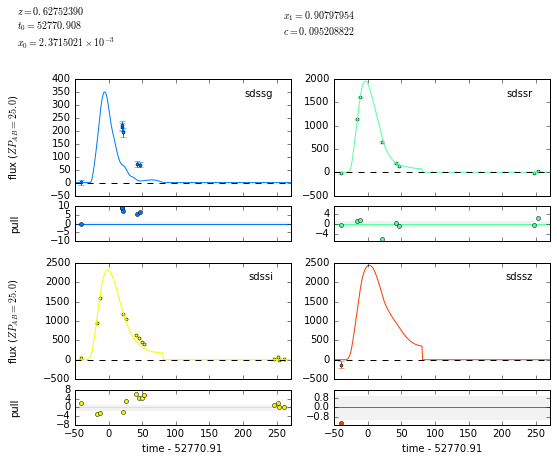

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:160: RuntimeWarning: Dropping following bands from data: sdssg, sdssz(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


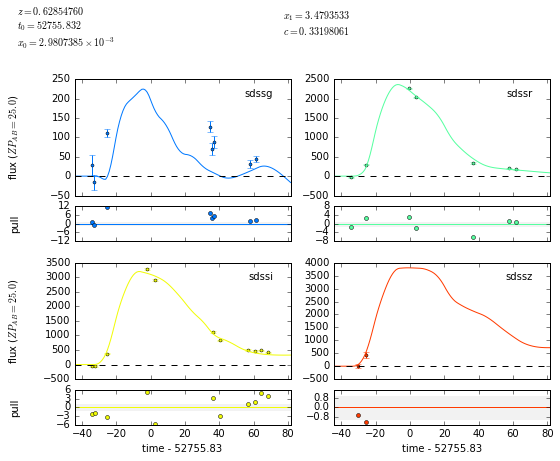

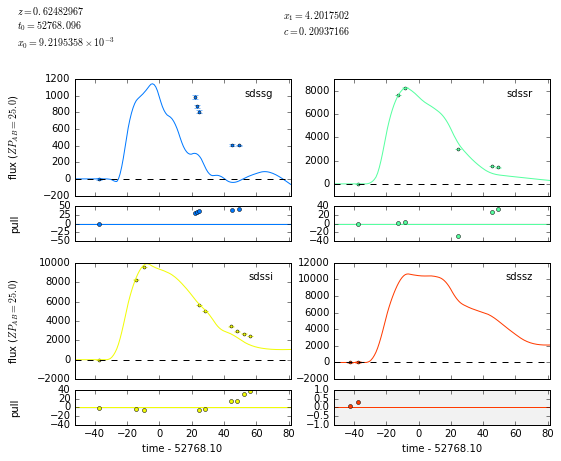

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:160: RuntimeWarning: Dropping following bands from data: sdssg(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


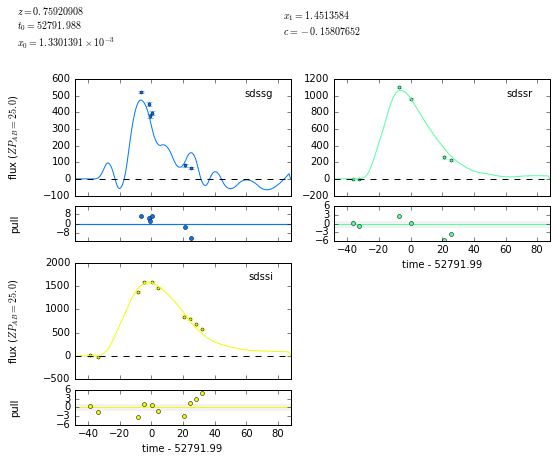

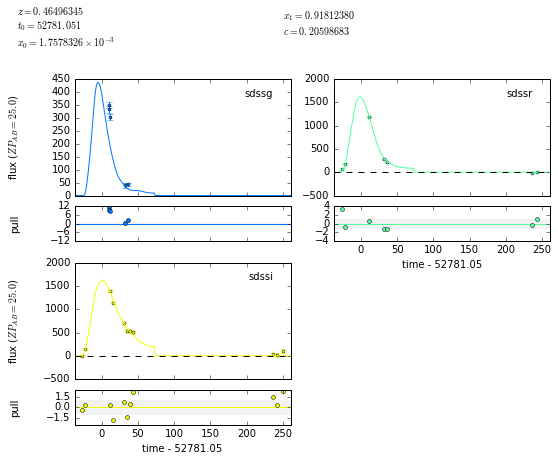

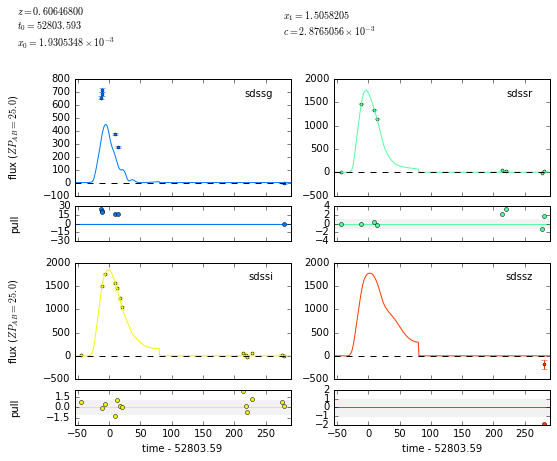

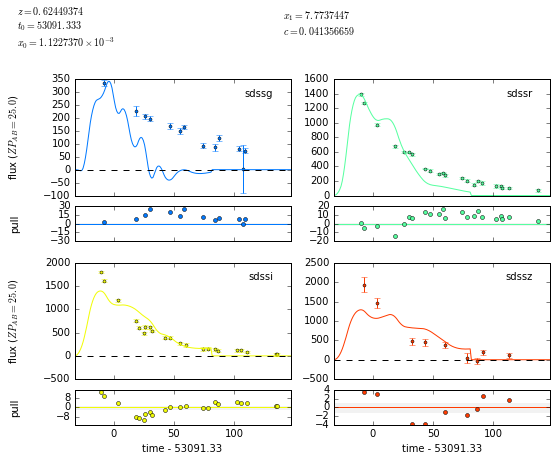

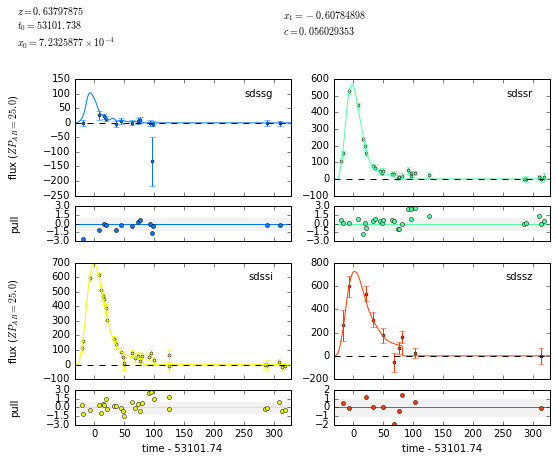

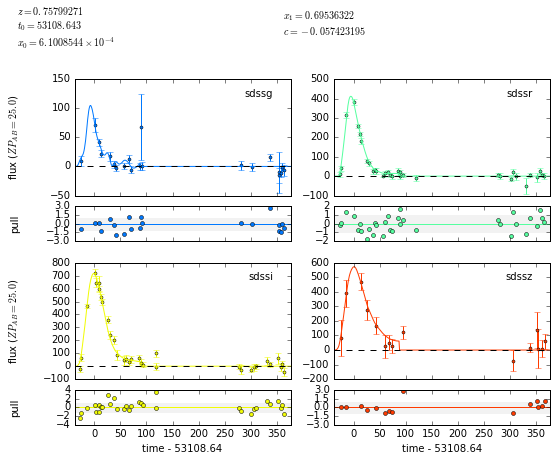

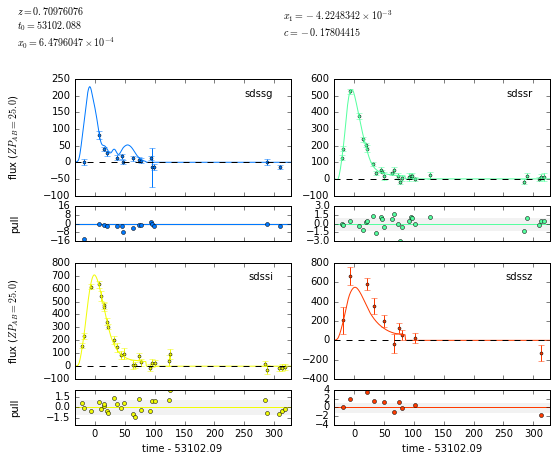

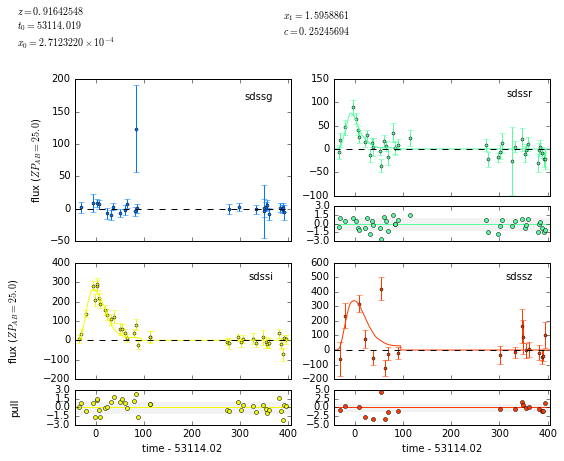

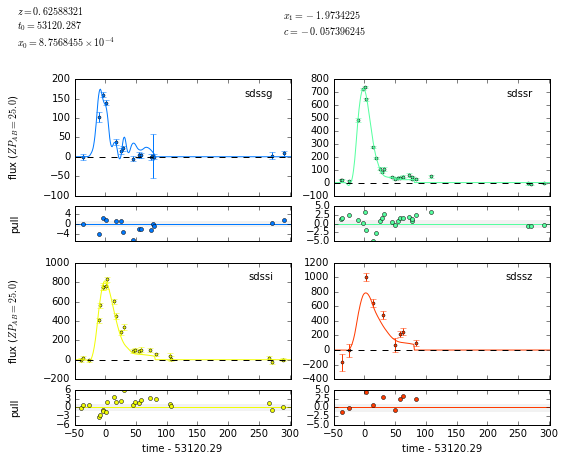

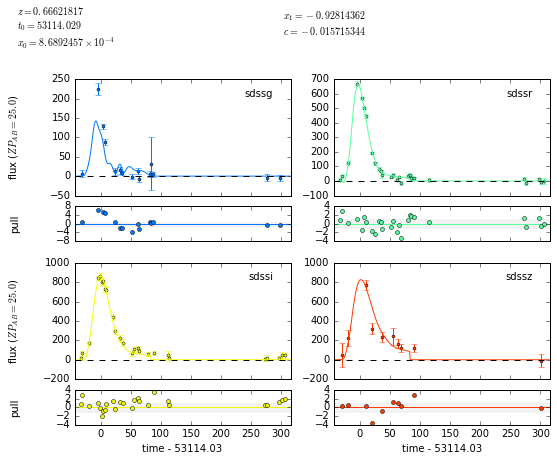

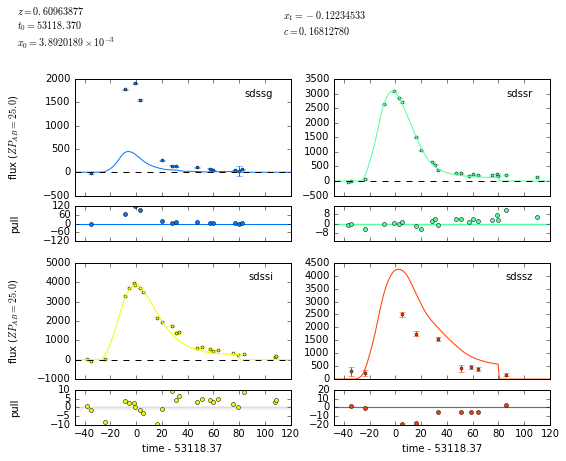

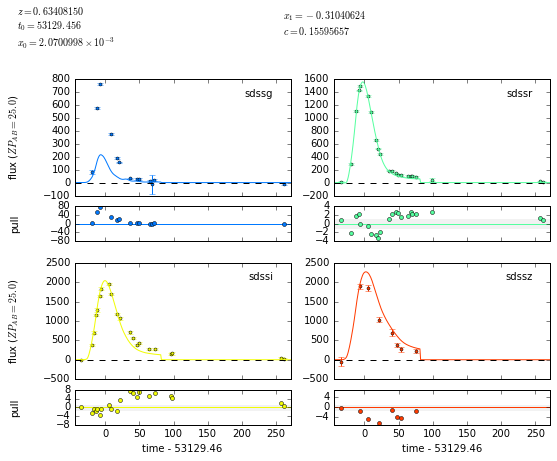

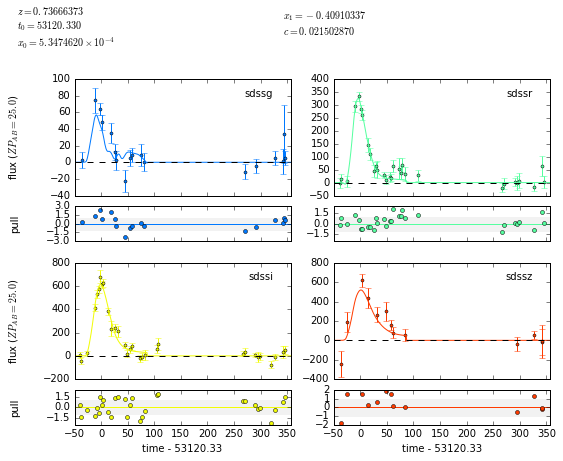

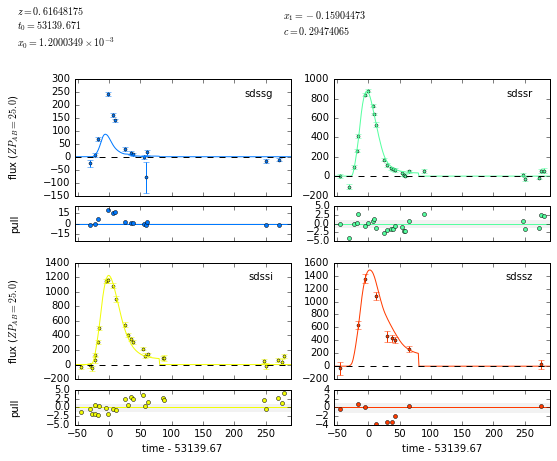

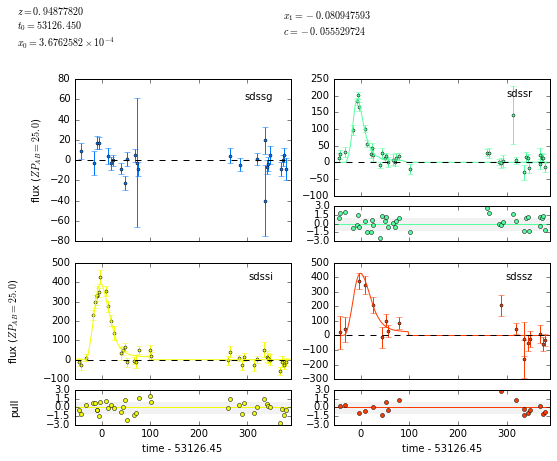

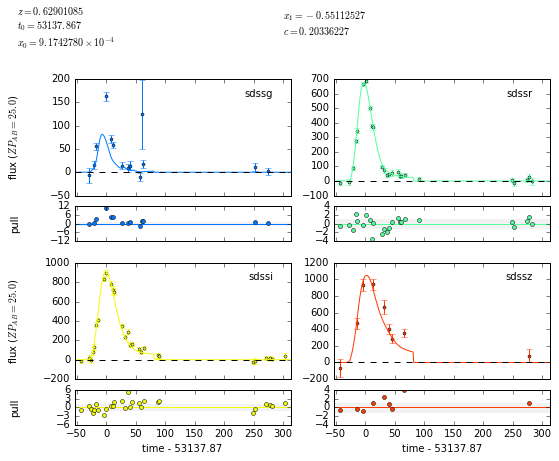

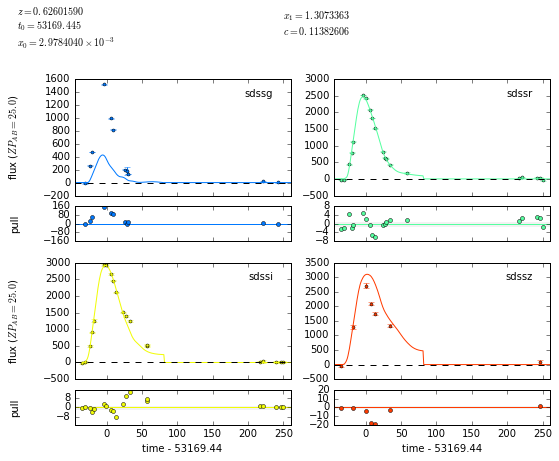

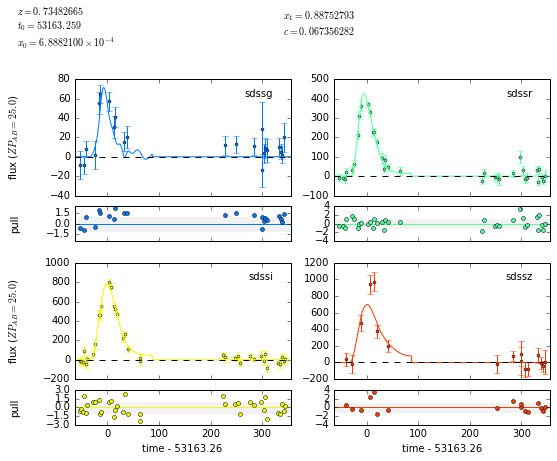

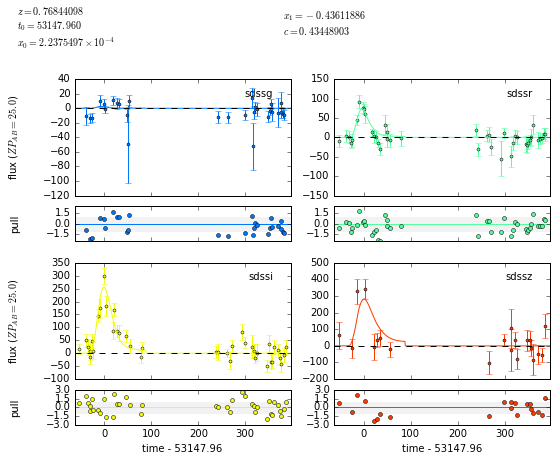

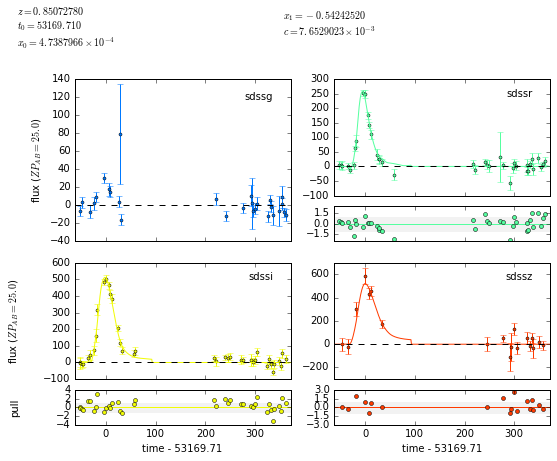

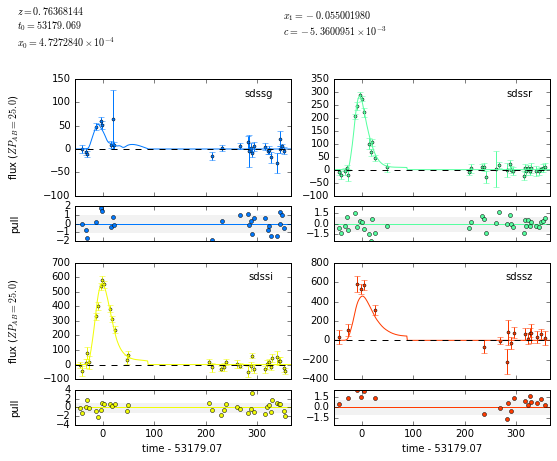

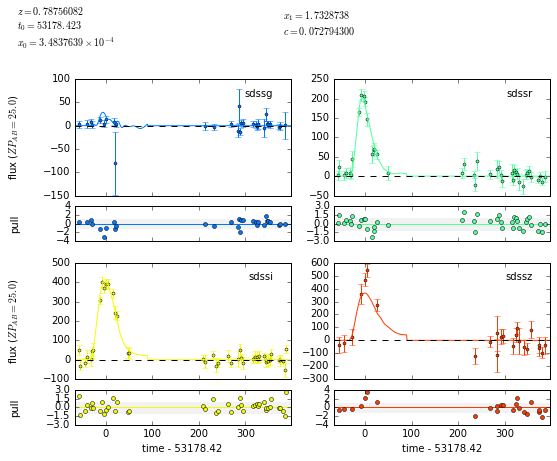

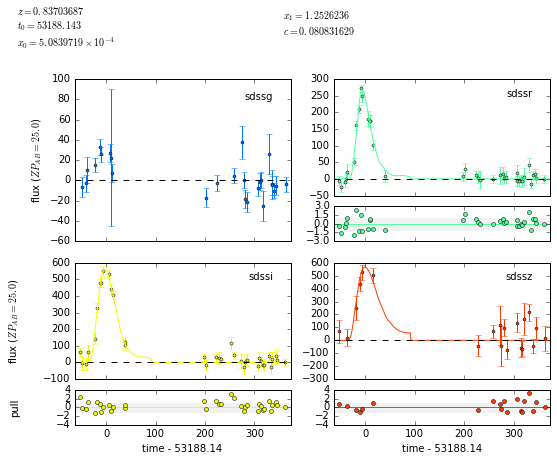

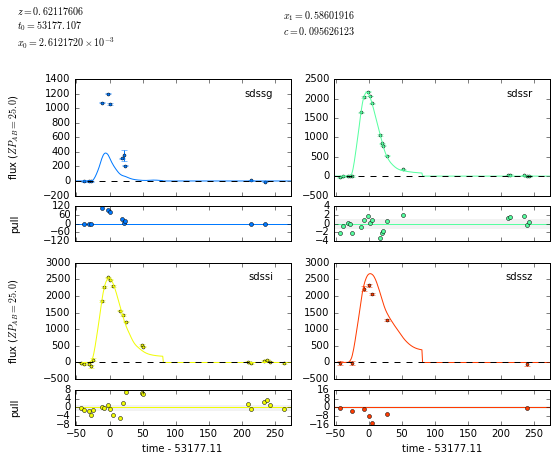

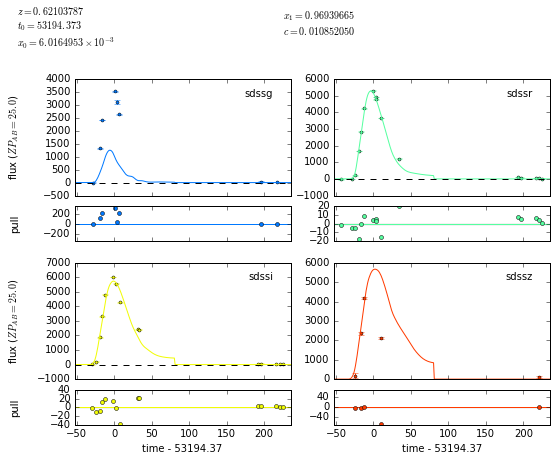

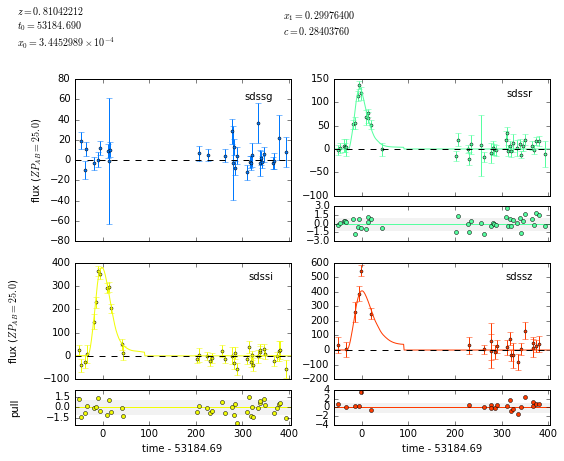

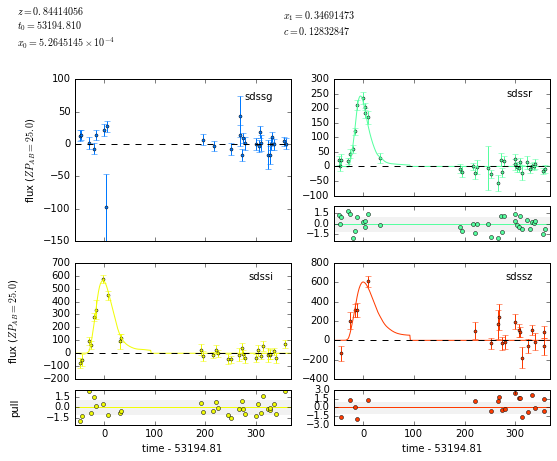

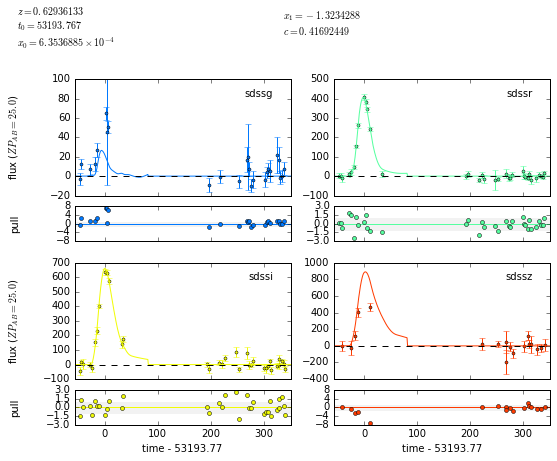

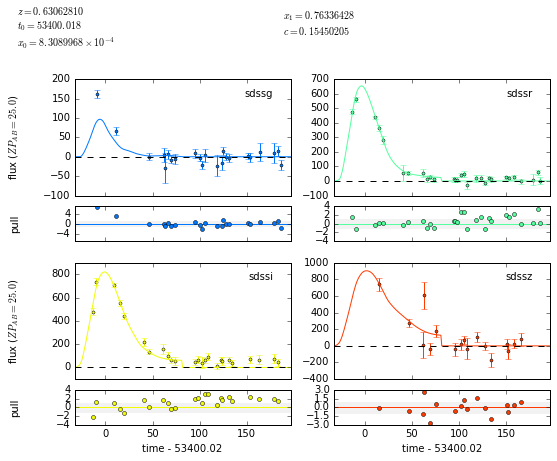

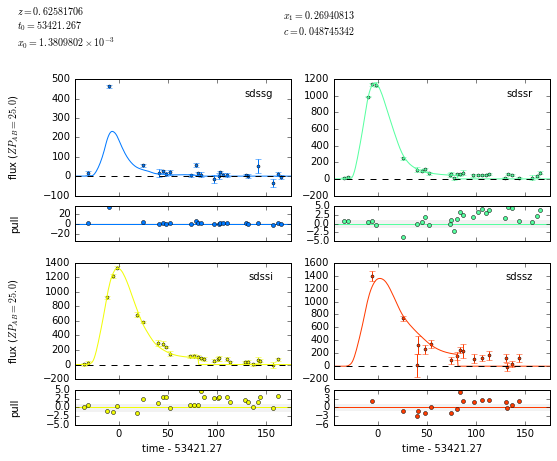

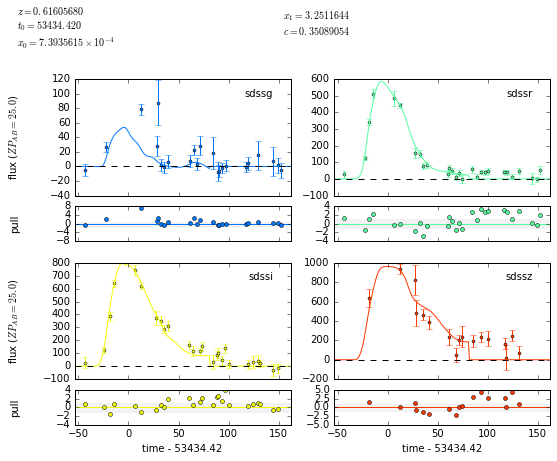

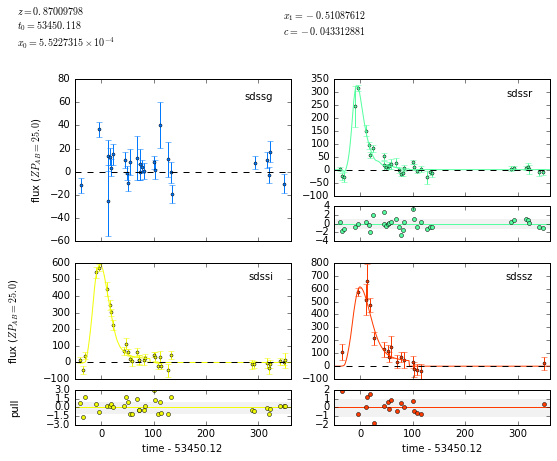

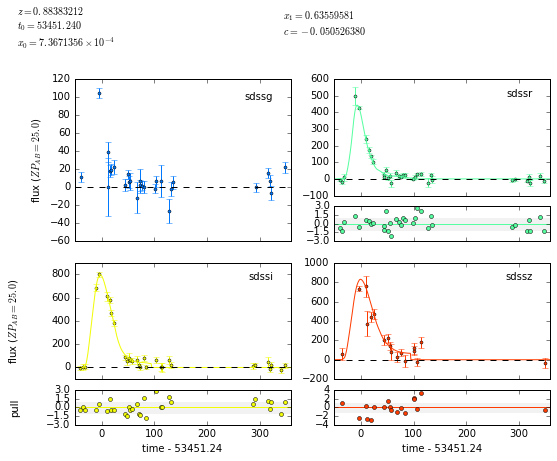

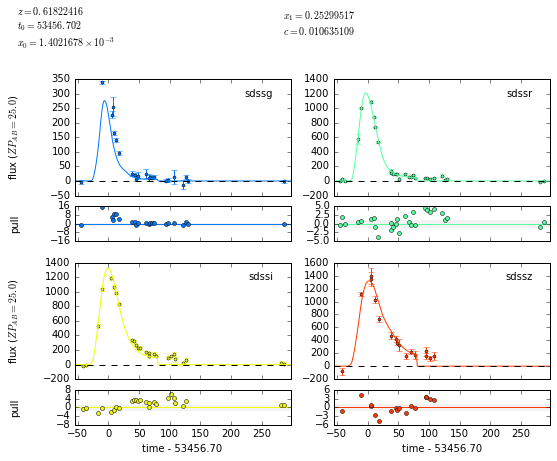

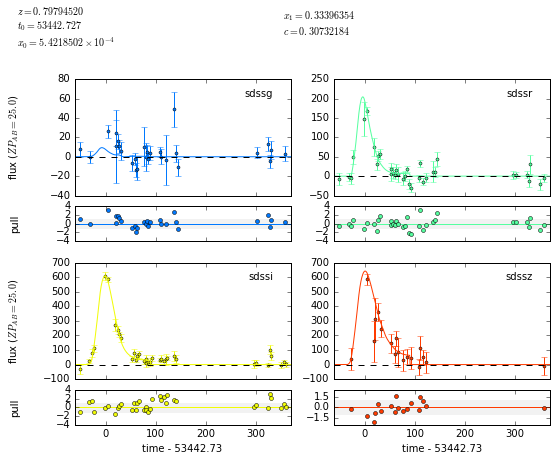

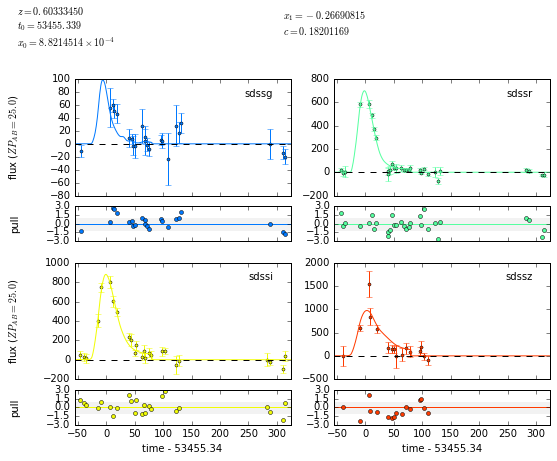

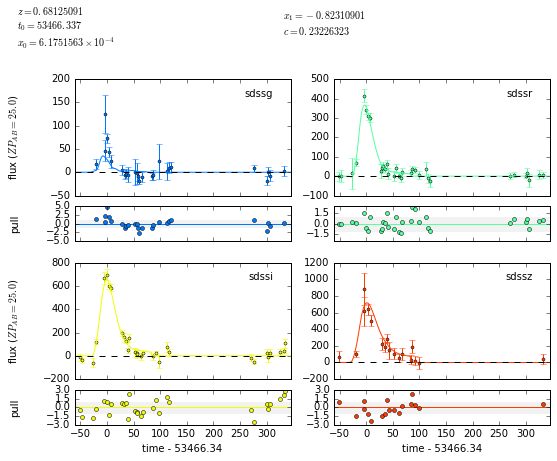

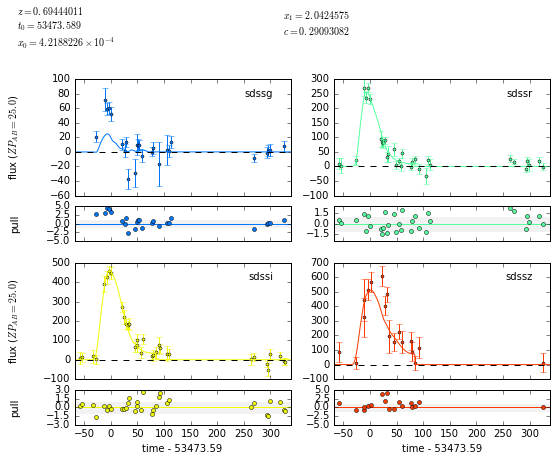

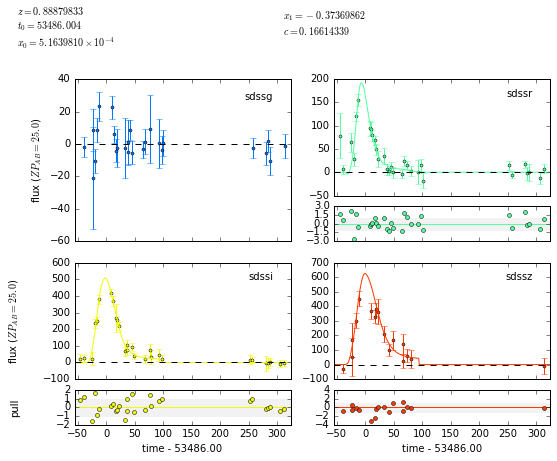

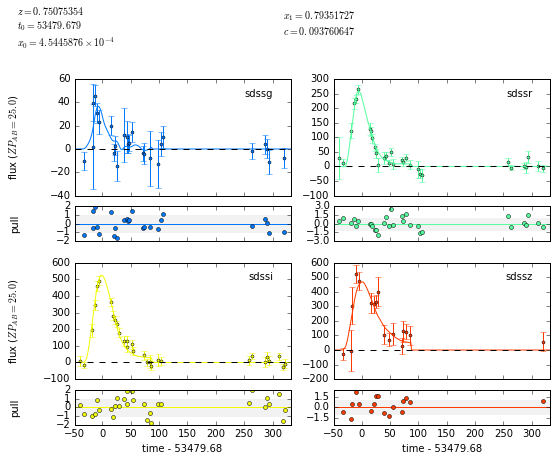

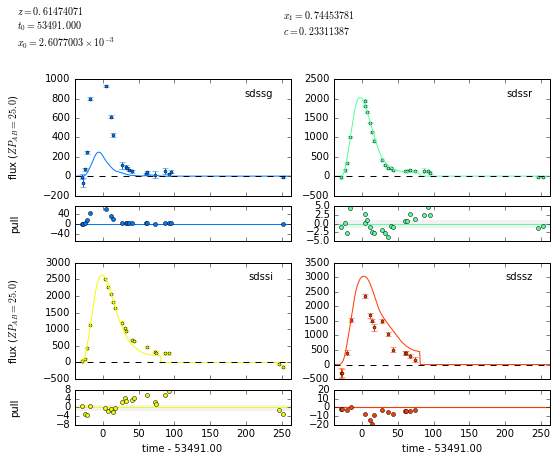

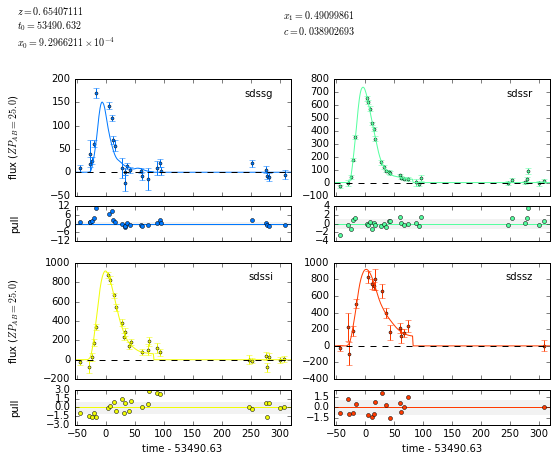

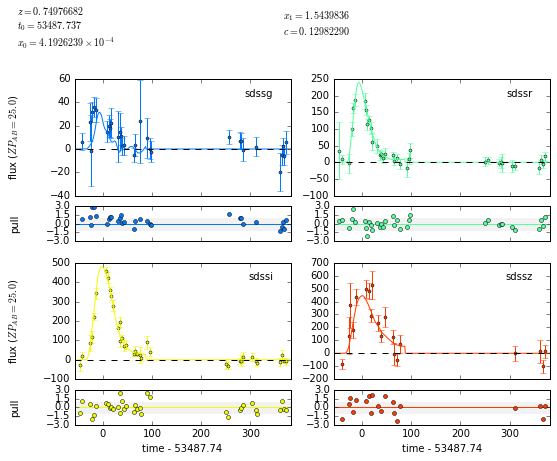

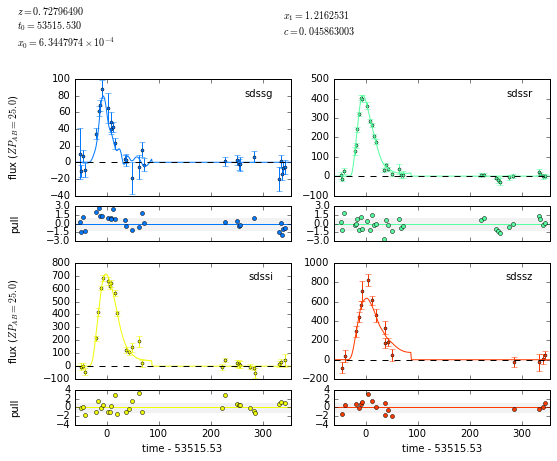

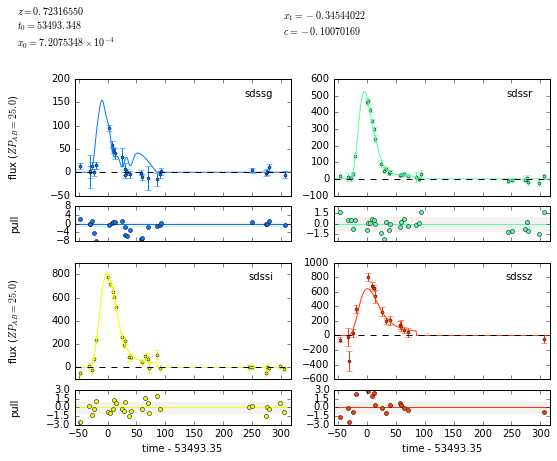

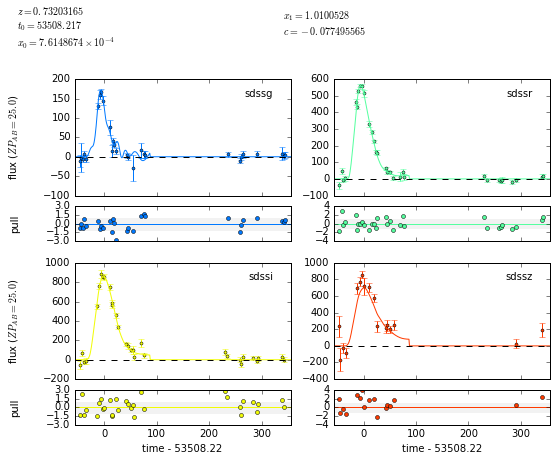

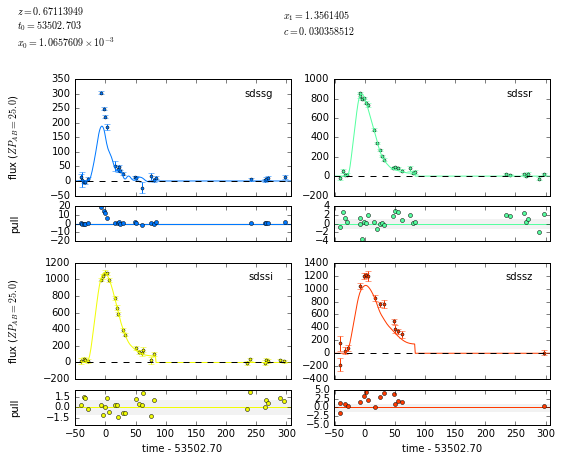

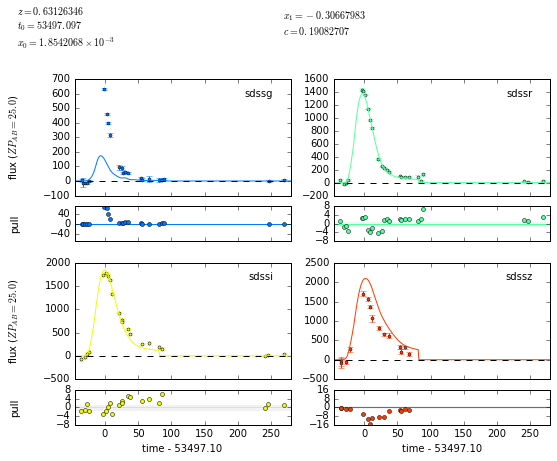

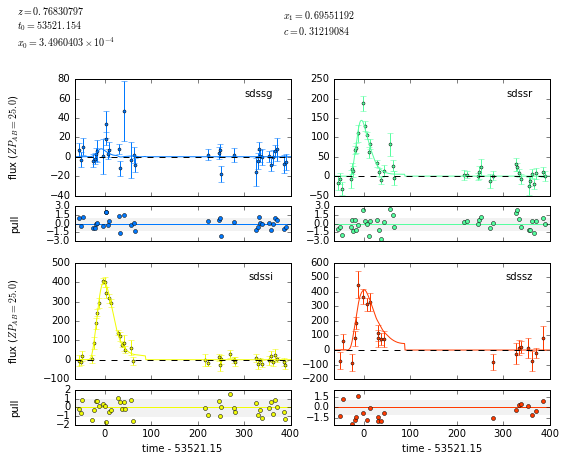

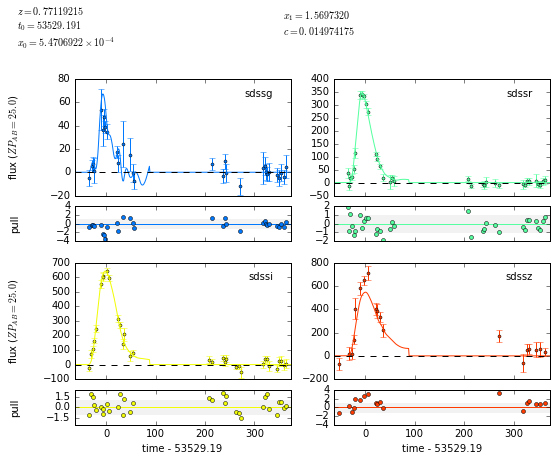

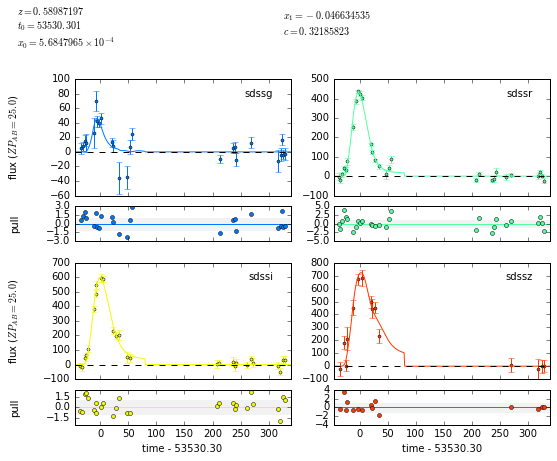

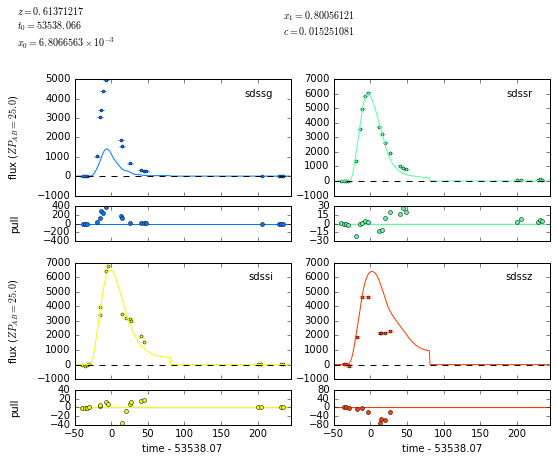

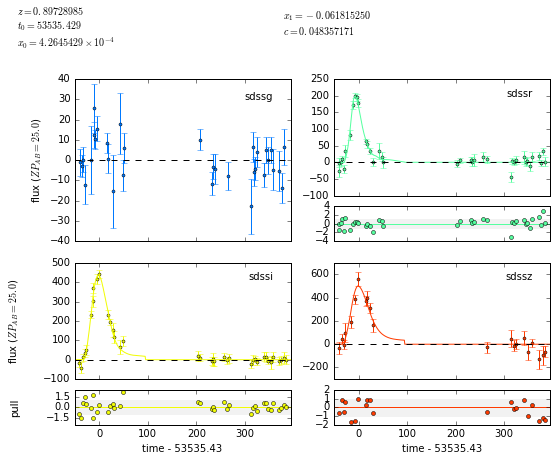

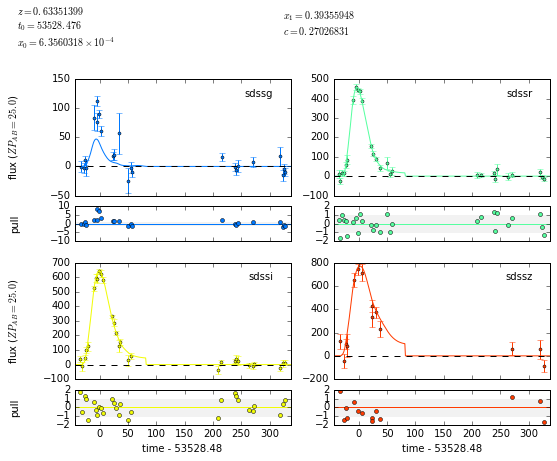

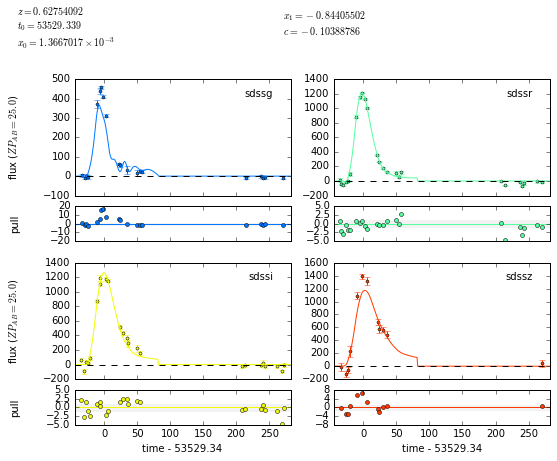

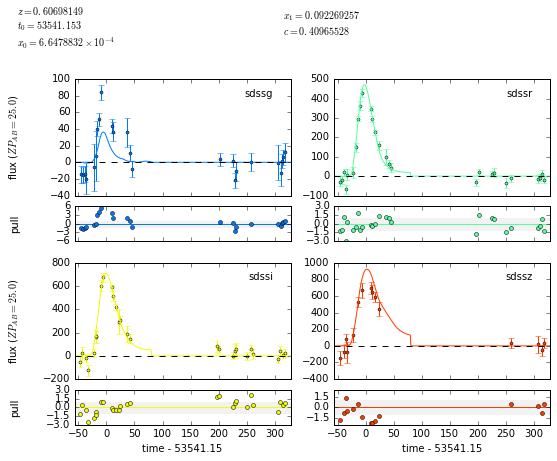

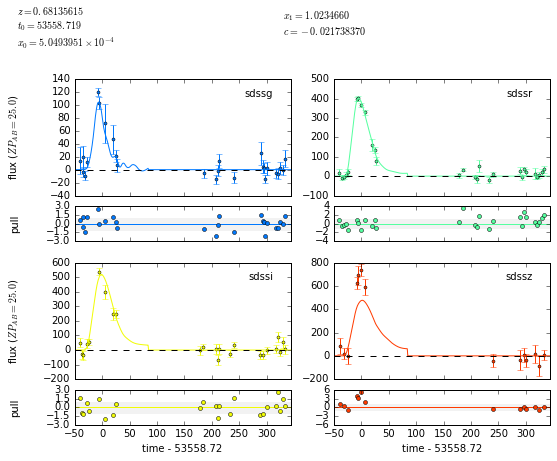

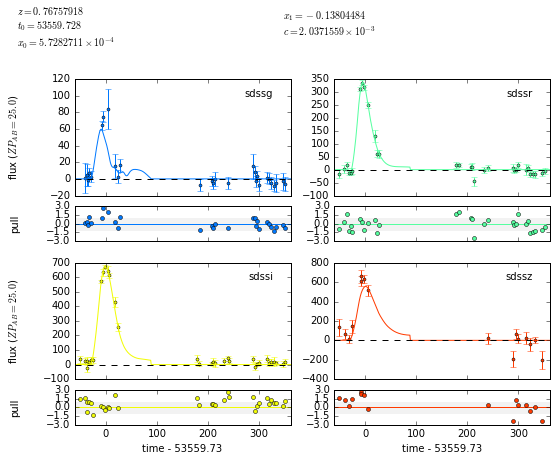

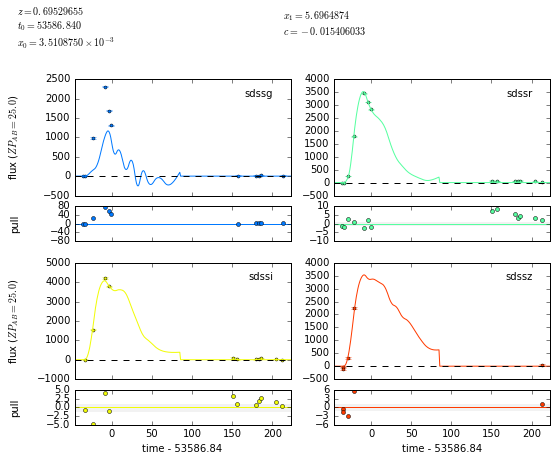

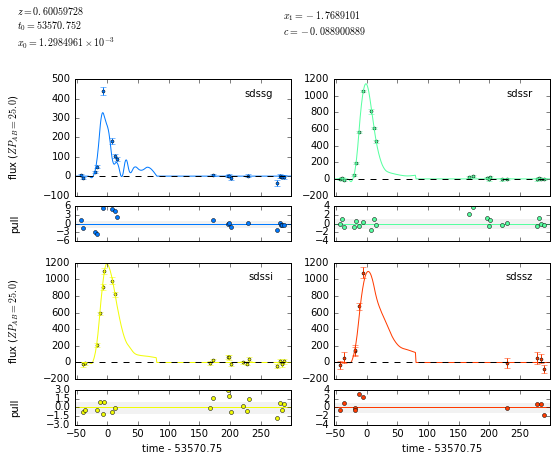

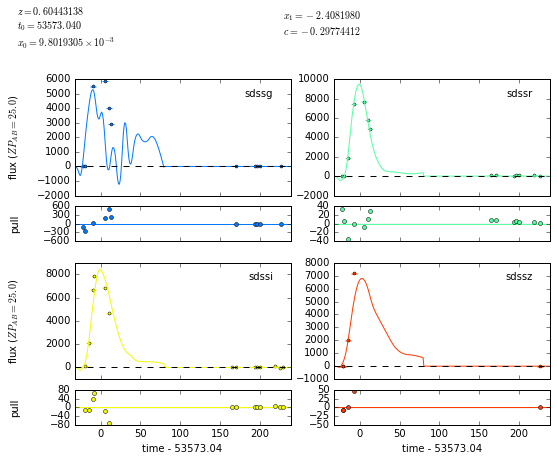

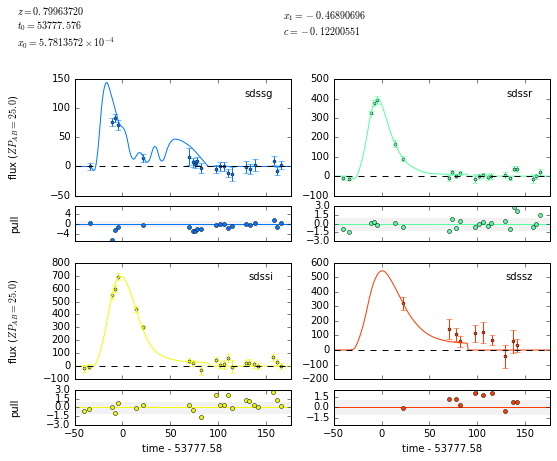

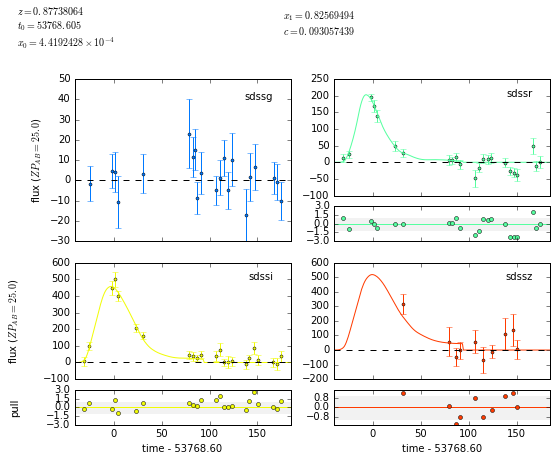

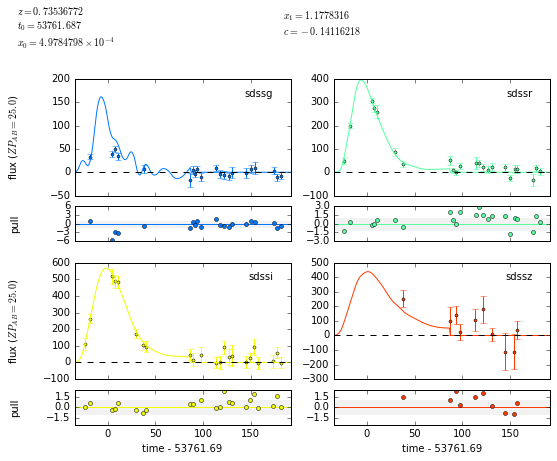

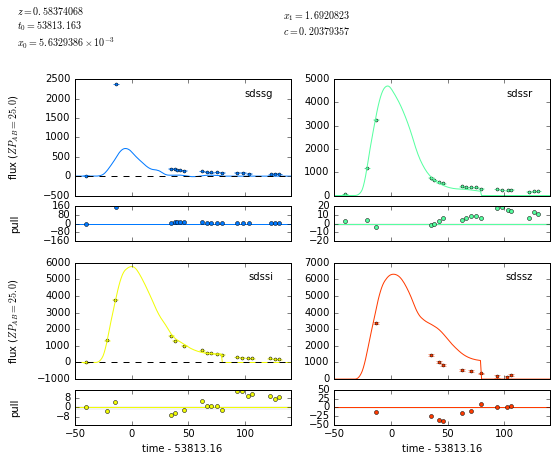

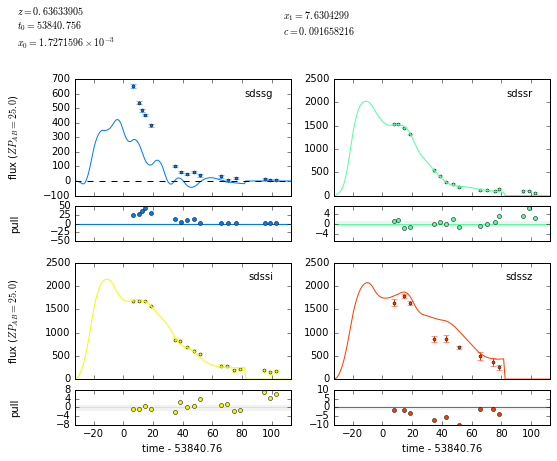

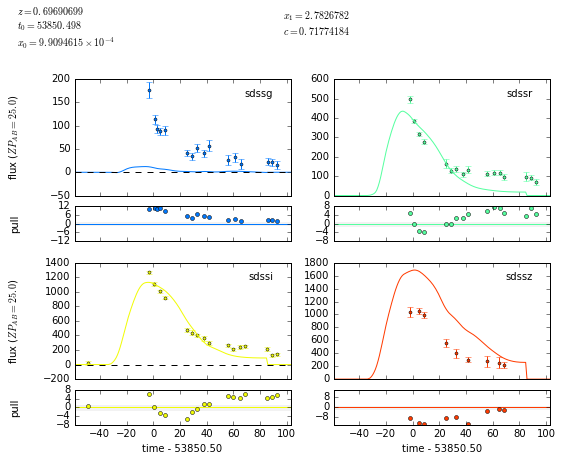

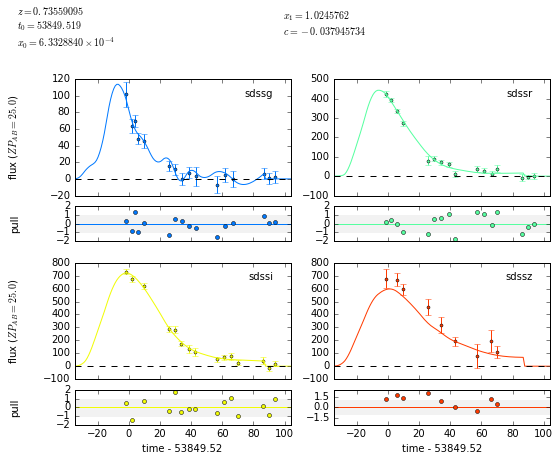

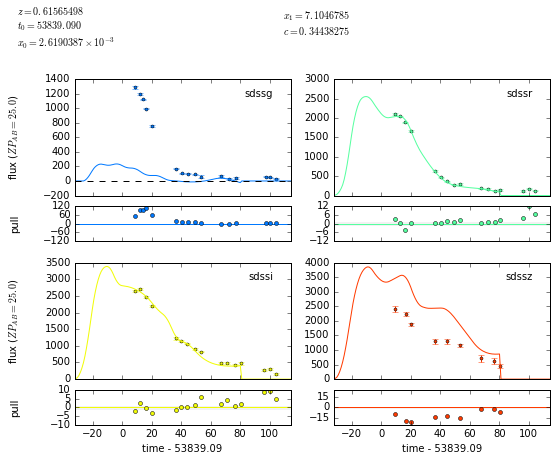

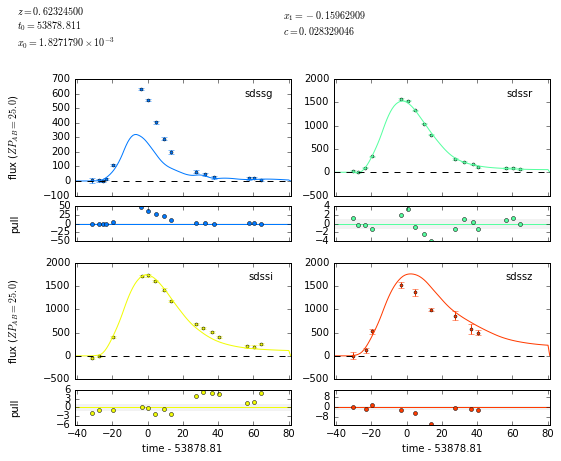

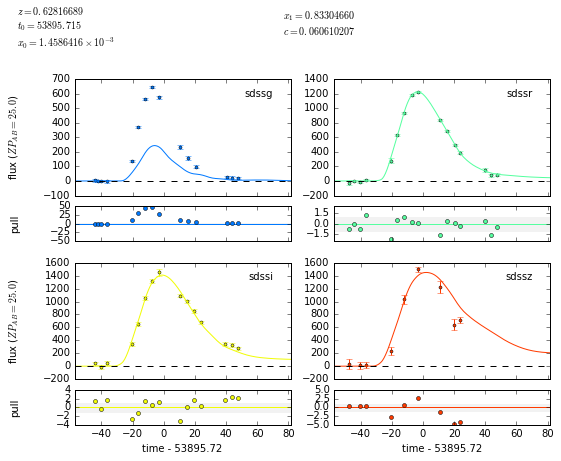

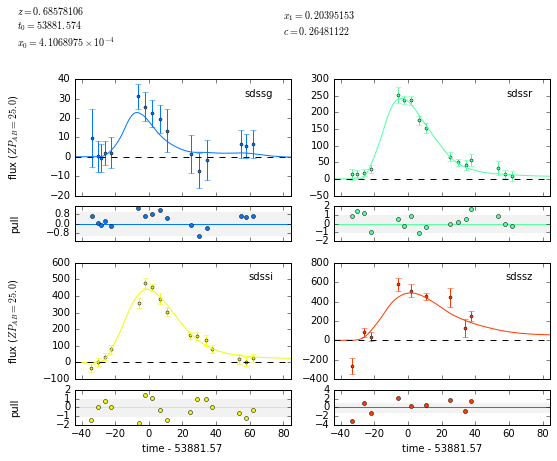

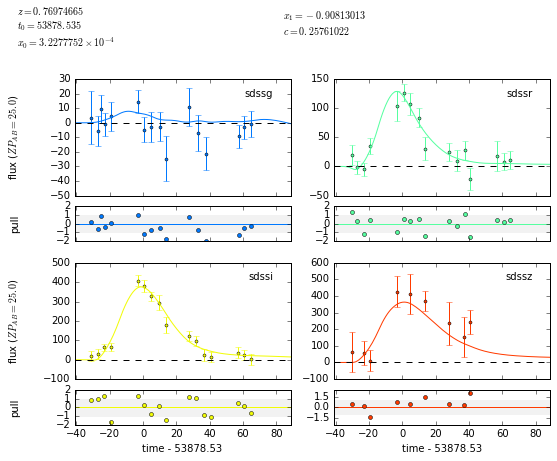

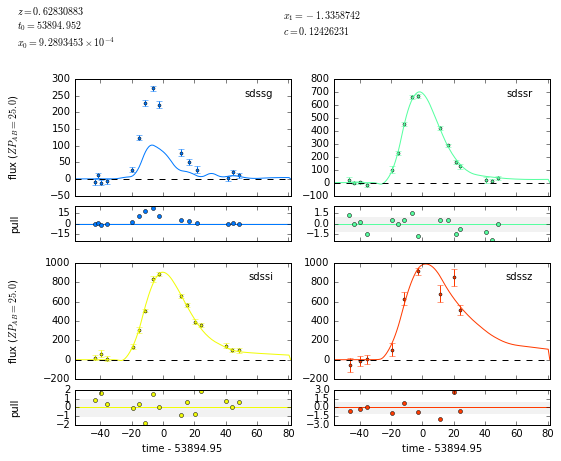

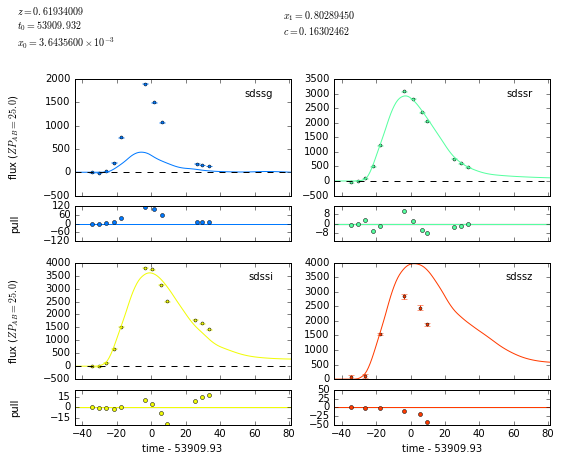

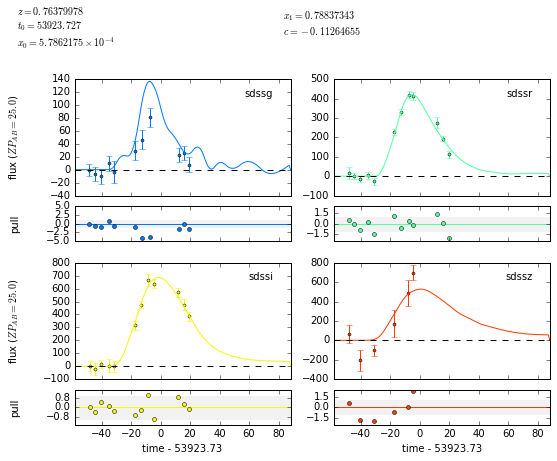

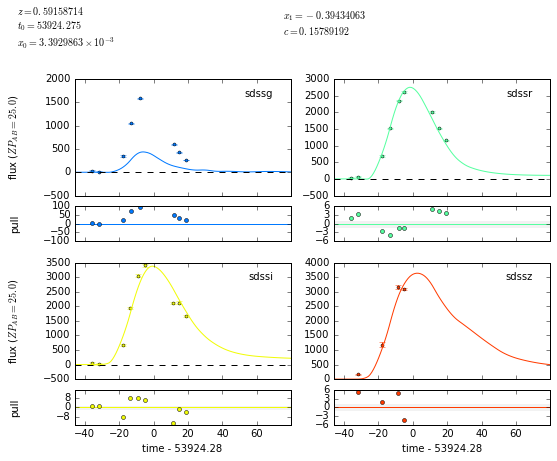

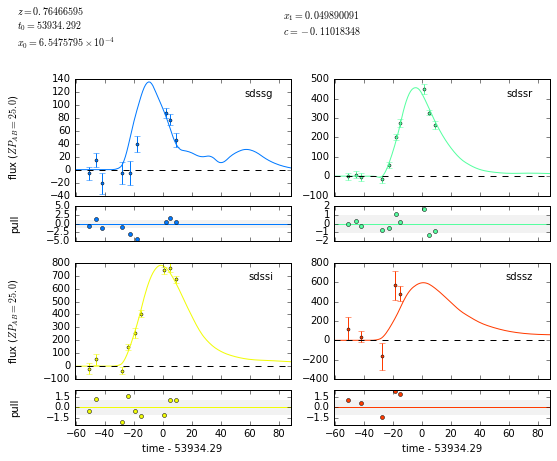

In [6]:
f_models = []
chi_sqrds = []
Zs = []
errors = 0
for s in snls_array:
    
    try:
        #This instruction loades the model
        model = sncosmo.Model(source='salt2')
        #This fits the light curve, s is the light curve, model is the loaded model, the next array indicates the values to be estimates and bounds helps to give a range for Redshift
        res, fitted_model = sncosmo.fit_lc(s, model, ['z', 't0', 'x0', 'x1', 'c'],  bounds={'z':(0.1, 1.3)})
        Zs.append(fitted_model.get("z"))
        #Instruction to plot the result with the fitted model
        sncosmo.plot_lc(s, model=fitted_model)
        plt.show()
        #Getting the number of degrees of fitting
        df = res.ndof  # number of degrees of freedom in fit
        #Getting the Chi Squared 
        chisq = res.chisq
        f_models.append(fitted_model)
        chi_sqrds.append(chisq/df)
    except Exception as e:
        print e
        errors+=1
        continue

In [10]:
diff_z= []
for lc, z_snls in zip(snls_array, Zs):
    diff_z.append(float(z_snls)-float(lc[0]["z"]))

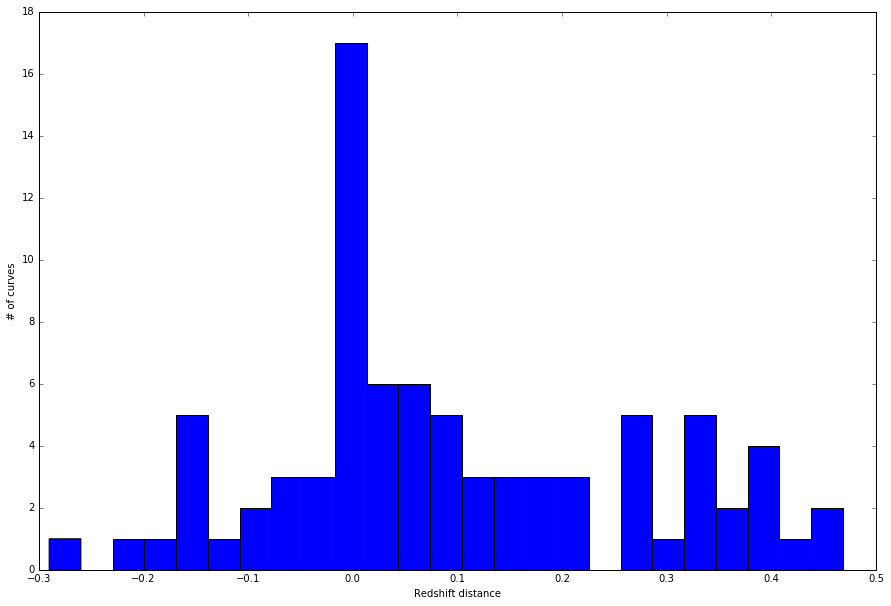

In [17]:
plt.figure(figsize=(15,10))
plt.hist(diff_z, bins=25)
plt.xlabel("Redshift distance")
plt.ylabel("# of curves")
plt.show()

In [12]:
def skewed_gaussian_chi(lc):
    lc_c = []

    mask = lc["bandpass"] == "sdssi"
    lc_c.append(lc[mask])

    mask = lc["bandpass"] == "sdssg"
    lc_c.append(lc[mask])

    mask = lc["bandpass"] == "sdssz"
    lc_c.append(lc[mask])

    mask = lc["bandpass"] == "sdssr"
    lc_c.append(lc[mask])
    
    chi_sqrds = []
    dofs = []
    
    for l in lc_c:
        
        if len(l) > 5:
            try:
                opt, pcov, chi, dof = show_fit_mod_gaussians(l, snls_colors, plot=False)
                chi_sqrds.append(chi)
                dofs.append(dof)
            except Exception as e:
                print e
                chi_sqrds.append(10000)
                dofs.append(1)

      
        
    return np.sum(chi_sqrds)  / np.sum(dofs)

In [ ]:
values = []
for i, lc in enumerate(s_candidates):
    print ">>>>>>>>"+str(i)
    values.append(skewed_gaussian_chi(lc))
    
    

>>>>>>>>0
>>>>>>>>1


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


>>>>>>>>2
>>>>>>>>3
>>>>>>>>4
>>>>>>>>5


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


>>>>>>>>6
>>>>>>>>7
>>>>>>>>8


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


>>>>>>>>9
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>10
>>>>>>>>11
>>>>>>>>12
>>>>>>>>13
>>>>>>>>14
>>>>>>>>15
>>>>>>>>16
>>>>>>>>17
>>>>>>>>18
>>>>>>>>19
>>>>>>>>20
>>>>>>>>21
>>>>>>>>22
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>23
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>24
>>>>>>>>25
>>>>>>>>26
Optimal parameters not found: Number of calls to function has reached maxfev = 500000.
Optimal parameters not found: Number of calls to function has reached maxfev = 500000.
Optimal parameters not found: Number of calls to function has reached maxfev = 500000.
>>>>>>>>27
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>28
>>>>>>>>29
>>>>>>>>30
>>>>>>>>31
>>>>>>>>32
array must not contain infs or NaNs
array mu

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in divide


>>>>>>>>42
>>>>>>>>43
>>>>>>>>44
>>>>>>>>45
>>>>>>>>46
>>>>>>>>47
Optimal parameters not found: Number of calls to function has reached maxfev = 500000.
>>>>>>>>48
>>>>>>>>49
>>>>>>>>50
>>>>>>>>51
>>>>>>>>52
>>>>>>>>53
>>>>>>>>54
>>>>>>>>55
>>>>>>>>56
>>>>>>>>57
>>>>>>>>58
>>>>>>>>59
>>>>>>>>60
>>>>>>>>61
>>>>>>>>62
>>>>>>>>63
>>>>>>>>64
>>>>>>>>65
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>66
>>>>>>>>67
>>>>>>>>68
>>>>>>>>69
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>70
>>>>>>>>71
>>>>>>>>72
>>>>>>>>73
>>>>>>>>74
>>>>>>>>75
>>>>>>>>76
>>>>>>>>77
>>>>>>>>78
>>>>>>>>79
>>>>>>>>80
>>>>>>>>81
>>>>>>>>82
>>>>>>>>83
>>>>>>>>84
>>>>>>>>85
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or Na

array must not contain infs or NaNs
>>>>>>>>431
>>>>>>>>432
>>>>>>>>433
>>>>>>>>434
>>>>>>>>435
>>>>>>>>436
>>>>>>>>437
>>>>>>>>438
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>439
>>>>>>>>440
array must not contain infs or NaNs
>>>>>>>>441
>>>>>>>>442
>>>>>>>>443
>>>>>>>>444
>>>>>>>>445
>>>>>>>>446
>>>>>>>>447
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>448
>>>>>>>>449
>>>>>>>>450
>>>>>>>>451
>>>>>>>>452
>>>>>>>>453
>>>>>>>>454
>>>>>>>>455
>>>>>>>>456
>>>>>>>>457
>>>>>>>>458
>>>>>>>>459
array must not contain infs or NaNs
>>>>>>>>460
>>>>>>>>461
>>>>>>>>462
>>>>>>>>463
>>>>>>>>464
>>>>>>>>465
>>>>>>>>466
Optimal parameters not found: Number of calls to function has reached maxfev = 500000.
>>>>>>>>467
>>>>>>>>468
>>>>>>>>469
>>>>>>>>470
>>>>>>>>471
Optimal parameters not found: Number of calls to function has reached maxfev = 500000.
>>>>>>>>472
>>>>>>>>473
>>>>>>>>474
array must not contain infs or NaNs
array must

>>>>>>>>792
>>>>>>>>793
>>>>>>>>794
>>>>>>>>795
>>>>>>>>796
>>>>>>>>797
>>>>>>>>798
>>>>>>>>799
>>>>>>>>800
>>>>>>>>801
>>>>>>>>802
>>>>>>>>803
>>>>>>>>804
>>>>>>>>805
>>>>>>>>806
>>>>>>>>807
>>>>>>>>808
>>>>>>>>809
>>>>>>>>810
>>>>>>>>811
>>>>>>>>812
>>>>>>>>813
>>>>>>>>814
>>>>>>>>815
>>>>>>>>816
>>>>>>>>817
>>>>>>>>818
>>>>>>>>819
>>>>>>>>820
>>>>>>>>821
>>>>>>>>822
>>>>>>>>823
>>>>>>>>824
>>>>>>>>825
>>>>>>>>826
>>>>>>>>827
>>>>>>>>828
>>>>>>>>829
>>>>>>>>830
>>>>>>>>831
>>>>>>>>832
>>>>>>>>833
>>>>>>>>834
>>>>>>>>835
>>>>>>>>836
>>>>>>>>837
>>>>>>>>838
>>>>>>>>839
>>>>>>>>840
>>>>>>>>841
>>>>>>>>842
>>>>>>>>843
>>>>>>>>844
>>>>>>>>845
>>>>>>>>846
>>>>>>>>847
>>>>>>>>848
>>>>>>>>849
>>>>>>>>850
>>>>>>>>851
>>>>>>>>852
>>>>>>>>853
>>>>>>>>854
>>>>>>>>855
>>>>>>>>856
>>>>>>>>857
array must not contain infs or NaNs
>>>>>>>>858
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>859
>>>>>>>>860
>>>>>>>>861
>>>>>>>>862
>>>>>>>>863


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:458: RuntimeWarning: invalid value encountered in multiply
  return weights * (func(xdata, *params) - ydata)


>>>>>>>>864
>>>>>>>>865
>>>>>>>>866
>>>>>>>>867
Optimal parameters not found: Number of calls to function has reached maxfev = 500000.
>>>>>>>>868
>>>>>>>>869
>>>>>>>>870
>>>>>>>>871
>>>>>>>>872
>>>>>>>>873
>>>>>>>>874
>>>>>>>>875
>>>>>>>>876
>>>>>>>>877
>>>>>>>>878
>>>>>>>>879
>>>>>>>>880
>>>>>>>>881
>>>>>>>>882
>>>>>>>>883
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>884
>>>>>>>>885
>>>>>>>>886
>>>>>>>>887
>>>>>>>>888
>>>>>>>>889
>>>>>>>>890
>>>>>>>>891
>>>>>>>>892
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>893
>>>>>>>>894
>>>>>>>>895
>>>>>>>>896
>>>>>>>>897
>>>>>>>>898
>>>>>>>>899
>>>>>>>>900
>>>>>>>>901
>>>>>>>>902
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>903
>>>>>>>>904
array must not contain infs or NaNs
>>>>>>>>905
>>>>>>>>906
>>>>>>>>907
>>>>>>>>908
>>>>>>>>909
>>>>>>>>910
>>>>>>>>911
>>>>>>>>912
>>>>>>>>913
>>>>>>>>914
>>>>>>>>915
>

array must not contain infs or NaNs
>>>>>>>>1251
>>>>>>>>1252
>>>>>>>>1253
>>>>>>>>1254
>>>>>>>>1255
>>>>>>>>1256
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>1257
>>>>>>>>1258
>>>>>>>>1259
>>>>>>>>1260
>>>>>>>>1261
>>>>>>>>1262
>>>>>>>>1263
>>>>>>>>1264
>>>>>>>>1265
>>>>>>>>1266
>>>>>>>>1267
>>>>>>>>1268
>>>>>>>>1269
>>>>>>>>1270
>>>>>>>>1271
>>>>>>>>1272
>>>>>>>>1273
>>>>>>>>1274
>>>>>>>>1275
>>>>>>>>1276
>>>>>>>>1277
>>>>>>>>1278
>>>>>>>>1279
>>>>>>>>1280
>>>>>>>>1281
>>>>>>>>1282
>>>>>>>>1283
>>>>>>>>1284
Optimal parameters not found: Number of calls to function has reached maxfev = 500000.
>>>>>>>>1285
>>>>>>>>1286
>>>>>>>>1287
>>>>>>>>1288
>>>>>>>>1289
>>>>>>>>1290
>>>>>>>>1291
Optimal parameters not found: Number of calls to function has reached maxfev = 500000.
>>>>>>>>1292
>>>>>>>>1293
>>>>>>>>1294
>>>>>>>>1295
>>>>>>>>1296
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
array must n

>>>>>>>>1621
array must not contain infs or NaNs
>>>>>>>>1622
>>>>>>>>1623
>>>>>>>>1624
>>>>>>>>1625
>>>>>>>>1626
>>>>>>>>1627
>>>>>>>>1628
Optimal parameters not found: Number of calls to function has reached maxfev = 500000.
>>>>>>>>1629
>>>>>>>>1630
>>>>>>>>1631
array must not contain infs or NaNs
>>>>>>>>1632
>>>>>>>>1633
>>>>>>>>1634
>>>>>>>>1635
>>>>>>>>1636
>>>>>>>>1637
>>>>>>>>1638
>>>>>>>>1639
>>>>>>>>1640
>>>>>>>>1641
>>>>>>>>1642
>>>>>>>>1643
>>>>>>>>1644
>>>>>>>>1645
>>>>>>>>1646
>>>>>>>>1647
>>>>>>>>1648
>>>>>>>>1649
>>>>>>>>1650
>>>>>>>>1651
>>>>>>>>1652
>>>>>>>>1653
>>>>>>>>1654
>>>>>>>>1655
>>>>>>>>1656
>>>>>>>>1657
>>>>>>>>1658
>>>>>>>>1659
Optimal parameters not found: Number of calls to function has reached maxfev = 500000.
>>>>>>>>1660
>>>>>>>>1661
>>>>>>>>1662
>>>>>>>>1663
>>>>>>>>1664
>>>>>>>>1665
>>>>>>>>1666
>>>>>>>>1667
>>>>>>>>1668
>>>>>>>>1669
>>>>>>>>1670
>>>>>>>>1671
>>>>>>>>1672
>>>>>>>>1673
>>>>>>>>1674
>>>>>>>>1675
>>>>>>>>1676
>>>>>>>>1677
>>>>>>>>1678


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


>>>>>>>>1778
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>1779
>>>>>>>>1780
>>>>>>>>1781
>>>>>>>>1782
>>>>>>>>1783
>>>>>>>>1784
>>>>>>>>1785
>>>>>>>>1786
>>>>>>>>1787
>>>>>>>>1788
>>>>>>>>1789
>>>>>>>>1790
>>>>>>>>1791
>>>>>>>>1792
>>>>>>>>1793
>>>>>>>>1794
>>>>>>>>1795
>>>>>>>>1796
>>>>>>>>1797
>>>>>>>>1798
>>>>>>>>1799
>>>>>>>>1800
>>>>>>>>1801
>>>>>>>>1802
>>>>>>>>1803
>>>>>>>>1804
>>>>>>>>1805
>>>>>>>>1806
>>>>>>>>1807
>>>>>>>>1808
>>>>>>>>1809
>>>>>>>>1810
>>>>>>>>1811
>>>>>>>>1812
>>>>>>>>1813
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>1814
>>>>>>>>1815
>>>>>>>>1816
>>>>>>>>1817
>>>>>>>>1818
>>>>>>>>1819
>>>>>>>>1820
>>>>>>>>1821
>>>>>>>>1822
>>>>>>>>1823
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>1824
>>>>>>>>1825
>>>>>>>>1826
>>>>>>>>1827
>>>>>>>>1828
>>>>>>>>1829


>>>>>>>>2127
>>>>>>>>2128
>>>>>>>>2129
>>>>>>>>2130
>>>>>>>>2131
>>>>>>>>2132
>>>>>>>>2133
>>>>>>>>2134
>>>>>>>>2135
>>>>>>>>2136
>>>>>>>>2137
array must not contain infs or NaNs
>>>>>>>>2138
>>>>>>>>2139
>>>>>>>>2140
>>>>>>>>2141
>>>>>>>>2142
>>>>>>>>2143
>>>>>>>>2144
>>>>>>>>2145
>>>>>>>>2146
array must not contain infs or NaNs
>>>>>>>>2147
>>>>>>>>2148
>>>>>>>>2149
>>>>>>>>2150
>>>>>>>>2151
>>>>>>>>2152
>>>>>>>>2153
>>>>>>>>2154
>>>>>>>>2155
>>>>>>>>2156
>>>>>>>>2157
>>>>>>>>2158
>>>>>>>>2159
>>>>>>>>2160
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>2161
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>2162
>>>>>>>>2163
>>>>>>>>2164
>>>>>>>>2165
>>>>>>>>2166
>>>>>>>>2167
array must not contain infs or NaNs
>>>>>>>>2168
>>>>>>>>2169
>>>>>>>>2170
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>2171
>>>>>>>>2172
>>>>>>>>2173
>>>>>>>>2174
>>>>>>>>2175
>>>

>>>>>>>>2485
>>>>>>>>2486
>>>>>>>>2487
>>>>>>>>2488
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>2489
>>>>>>>>2490
>>>>>>>>2491
>>>>>>>>2492
array must not contain infs or NaNs
>>>>>>>>2493
>>>>>>>>2494
Optimal parameters not found: Number of calls to function has reached maxfev = 500000.
>>>>>>>>2495
>>>>>>>>2496
>>>>>>>>2497
>>>>>>>>2498
>>>>>>>>2499
Optimal parameters not found: Number of calls to function has reached maxfev = 500000.
Optimal parameters not found: Number of calls to function has reached maxfev = 500000.
Optimal parameters not found: Number of calls to function has reached maxfev = 500000.
Optimal parameters not found: Number of calls to function has reached maxfev = 500000.
>>>>>>>>2500
>>>>>>>>2501
>>>>>>>>2502
>>>>>>>>2503
>>>>>>>>2504
>>>>>>>>2505
>>>>>>>>2506
>>>>>>>>2507
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not

>>>>>>>>2822
>>>>>>>>2823
>>>>>>>>2824
>>>>>>>>2825
>>>>>>>>2826
>>>>>>>>2827
>>>>>>>>2828
>>>>>>>>2829
>>>>>>>>2830
>>>>>>>>2831
>>>>>>>>2832
>>>>>>>>2833
>>>>>>>>2834
Optimal parameters not found: Number of calls to function has reached maxfev = 500000.
>>>>>>>>2835
>>>>>>>>2836
>>>>>>>>2837
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>2838
array must not contain infs or NaNs
>>>>>>>>2839
>>>>>>>>2840
>>>>>>>>2841
>>>>>>>>2842
>>>>>>>>2843
>>>>>>>>2844
>>>>>>>>2845
>>>>>>>>2846
>>>>>>>>2847
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>2848
>>>>>>>>2849
>>>>>>>>2850
>>>>>>>>2851
>>>>>>>>2852
>>>>>>>>2853
>>>>>>>>2854
>>>>>>>>2855
>>>>>>>>2856
>>>>>>>>2857
>>>>>>>>2858
>>>>>>>>2859
array must not contain infs or NaNs
>>>>>>>>2860
>>>>>>>>2861
>>>>>>>>2862
>>>>>>>>2863
>>>>>>>>2864
>>>>>>>>2865
>>>>>>>>2866
array must not contain infs or NaNs
arra

>>>>>>>>3106
>>>>>>>>3107
>>>>>>>>3108
>>>>>>>>3109
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>3110
>>>>>>>>3111
>>>>>>>>3112
>>>>>>>>3113
>>>>>>>>3114
>>>>>>>>3115
>>>>>>>>3116
>>>>>>>>3117
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>3118
>>>>>>>>3119
>>>>>>>>3120
array must not contain infs or NaNs
>>>>>>>>3121
>>>>>>>>3122
Optimal parameters not found: Number of calls to function has reached maxfev = 500000.
>>>>>>>>3123
Optimal parameters not found: Number of calls to function has reached maxfev = 500000.
>>>>>>>>3124
>>>>>>>>3125
>>>>>>>>3126
>>>>>>>>3127
array must not contain infs or NaNs
array must not contain infs or NaNs
array must not contain infs or NaNs
>>>>>>>>3128
>>>>>>>>3129
>>>>>>>>3130
>>>>>>>>3131
>>>>>>>>3132
>>>>>>>>3133
>>>>>>>>3134
>>>>>>>>3135
>>>>>>>>3136
>>>>>>>>3137
>>>>>>>>3138
>>>>>>>>3139
>>>>>>>>3140
>>>>>>>>3141
>>>>>>>>3142
>>>>>>>>3143
Optimal 

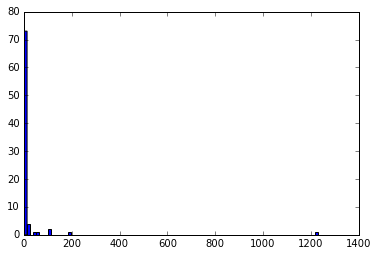

(72, ' of ', 83)


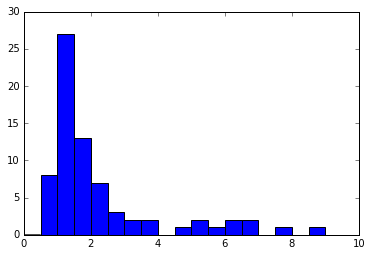

In [90]:
plt.hist(values, bins=100)
plt.show()


a = np.array(values)
b = a[a < 10]
plt.hist(b, bins=20, range=(0,10))
print(len(b), " of ",len(chi_sqrds))